In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, t

#second version

sns.set(style="whitegrid", font_scale=1.1)

df_species = pd.read_csv("data/processed/species.csv")
df_sites = pd.read_csv("data/processed/sites.csv")
df_observations = pd.read_csv("data/processed/observations.csv")

/tmp/ipykernel_17594/2518284138.py:15: DtypeWarning: Columns (12,13,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_observations = pd.read_csv("data/processed/observations.csv")


In [2]:
# Let's get interested by the evolutions of species
species = df_observations["clean_espece"].unique()
evolutionSpecies = {name : pd.Series() for name in species}


for specie in species:

    df_cut = df_observations[df_observations["clean_espece"] == specie]
    evolution = df_cut.groupby("year")["Amount"].sum()

    if 2014 in evolution.keys():
        evolution = evolution.drop(2014)

    evolutionSpecies[specie] = evolution

evolutionSpecies = pd.Series(evolutionSpecies)

In [3]:
# Let's identify the species wich are decreasing the most

changeSpecies = pd.Series(index = species)

length = 2025 - 2014 + 1

for specie in species:

    evol = evolutionSpecies[specie]

    lastInd = len(evol) - 1
    if lastInd > -1 and evol.iat[0] != 0.0:
        changeSpecies[specie] = 100*(evol.iat[lastInd] - evol.iat[0]) / evol.iat[0]




In [4]:
# Let's get the two species whose population has increased the most and the one who decreased the most

seuil = 220

minEsp, maxEsp = None, None
minChange, maxChange = np.inf, -np.inf 

for specie in species:
    evol = evolutionSpecies[specie]
    rateChange = changeSpecies[specie]

    if len(evol) > 0 and not(pd.isna(rateChange)) and evol.iat[0] > seuil :

        if rateChange < minChange:
            minChange = rateChange
            minEsp = specie

        if rateChange > maxChange:
            maxChange = rateChange
            maxEsp = specie


The specie of bird that had the biggest increase of its population between 2015 and 2025 is the tourterelle turque
They went from a population of 329.0 in 2015 to 885.0, increasing by 169.00 %.
---------------------------------------------------------------------------------------------
The specie of bird that had the biggest decrease of its population between 2015 and 2025 is the colibri falle-vert
They went from a population of 226.0 in 2015 to 105.0, decreasing by 53.54 %.
---------------------------------------------------------------------------------------------
Index([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025], dtype='int64', name='year')


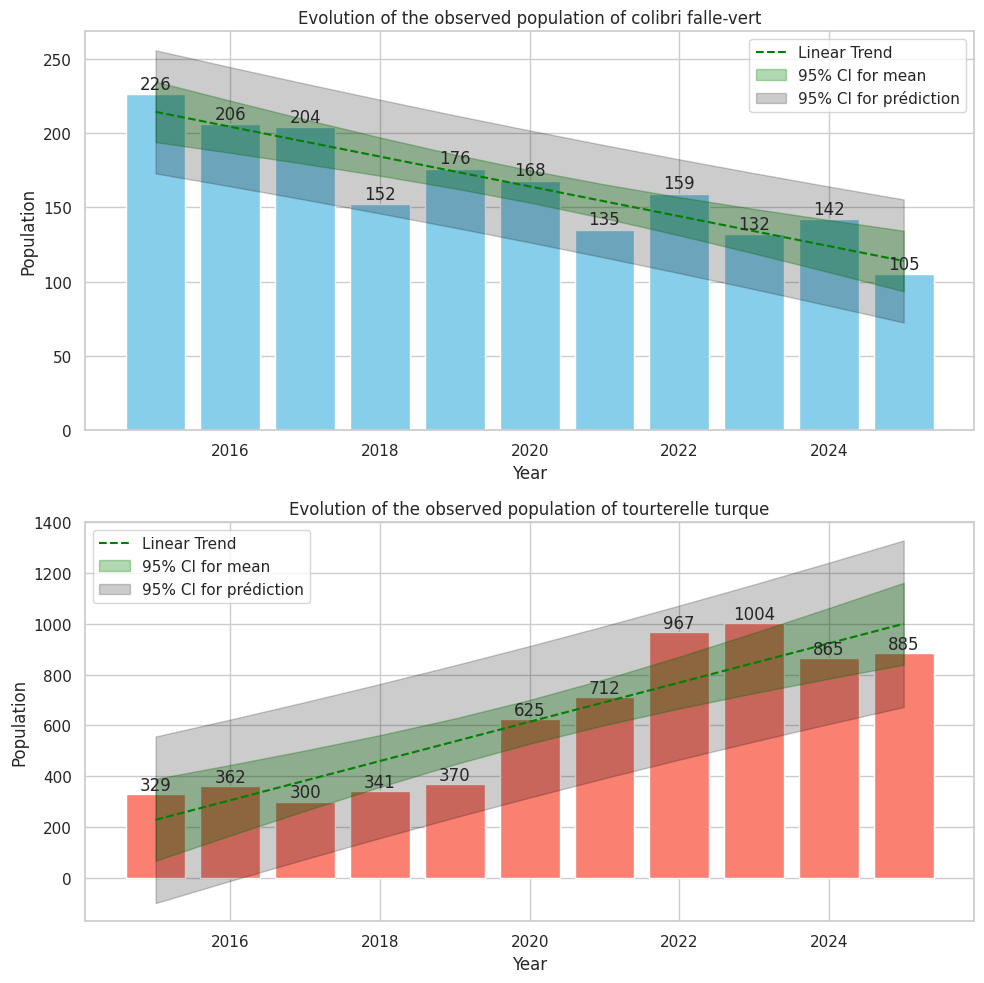

In [ ]:
maxEvol = evolutionSpecies[maxEsp]

popBegin = maxEvol.iat[0]
popEnd = maxEvol.iat[len(maxEvol) - 1]
change = changeSpecies[maxEsp]

print(f"The specie of bird that had the biggest increase of its population between 2015 and 2025 is the {maxEsp}")
print(f"They went from a population of {popBegin} in 2015 to {popEnd}, increasing by {change:.2f} %.")
print("---------------------------------------------------------------------------------------------")


minEvol = evolutionSpecies[minEsp]

popBegin = minEvol.iat[0]
popEnd = minEvol.iat[len(minEvol) - 1]
change = changeSpecies[minEsp]

print(f"The specie of bird that had the biggest decrease of its population between 2015 and 2025 is the {minEsp}")
print(f"They went from a population of {popBegin} in 2015 to {popEnd}, decreasing by {np.abs(change):.2f} %.")
print("---------------------------------------------------------------------------------------------")
years = maxEvol.keys()
sns.set(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

def ci_linear_model(x, Y_real, Y_model, alpha=0.05):
    n = len(x)
    x_mean = np.mean(x)
    
    # Residuals and variance estimates
    residues = Y_real - Y_model
    SSE = np.sum(np.square(residues))
    MSE = SSE / (n - 2)
    Sxx = np.sum(np.square(x - x_mean))

    # t critical value
    t_crit = t.ppf(1 - alpha / 2, n - 2)

    SE_mean = np.sqrt(MSE * (1/n + (x - x_mean)**2 / Sxx))

    SE_pred = np.sqrt(MSE * (1 + 1/n + (x - x_mean)**2 / Sxx))
    # Margins of error for slope and intercept
   

    return t_crit * SE_mean, t_crit * SE_pred




def plot_with_trend(ax, x, y, color, title):
    # Bar plot
    ax.bar(x, y, color=color)
    
    X = np.column_stack((x.values, np.ones(len(x))))
    
    model = LinearRegression()
    model.fit(X, y)

    b1 = model.coef_[0]           # pente
    b0 = model.intercept_         # intercept


    y_pred = model.predict(X)
    
    err, err2 = ci_linear_model(np.array(x), y, y_pred, 0.05)


    y_lower = y_pred - err
    y_upper = y_pred + err
    
    y_lower_pred = y_pred - err2
    y_upper_pred = y_pred + err2

    ax.plot(x, y_pred, color='green', linestyle='--', label='Linear Trend')


    ax.fill_between(x, y_lower, y_upper, color='green', alpha=0.3, label='95% CI for mean')

    # Bande intervalle de prédiction
    ax.fill_between(x, y_lower_pred, y_upper_pred, color='black', alpha=0.2, label='95% CI for prédiction')    

    # Annotate bars
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2, p.get_height() + 1, int(p.get_height()),
                ha='center', va='bottom')
    
    ax.set_title(title)
    ax.set_ylabel('Population')
    ax.set_xlabel('Year')
    ax.legend()

# Plot minEvol
plot_with_trend(ax1, minEvol.keys(), minEvol, 'skyblue', f'Evolution of the observed population of {minEsp}')

# Plot maxEvol
plot_with_trend(ax2, maxEvol.keys(), maxEvol, 'salmon', f'Evolution of the observed population of {maxEsp}')

plt.tight_layout()
plt.savefig("figures/evolution_specie.jpeg")
plt.show()


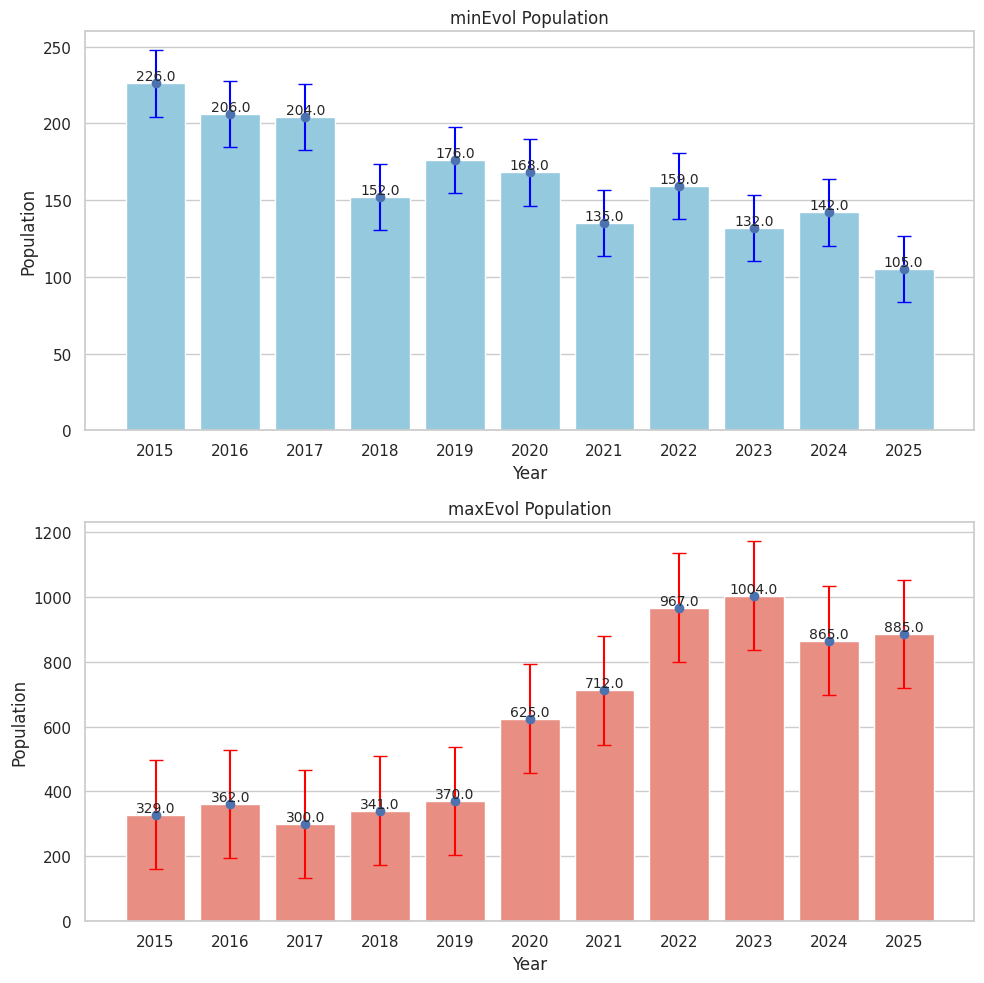

In [169]:
# Now lets' get interested to the COnfidence Intervals for the mean and variance of those two species per year using the bootstrap method

alpha = 0.05

sigmaMinEvol = minEvol.std(ddof=1)
sigmaMaxEvol = maxEvol.std(ddof=1)



n = len(years)

CIMinEvol = pd.Series(index=years, dtype=object)
CIMaxEvol = pd.Series(index=years, dtype=object)

errMinEvols = pd.Series(index = years)
errMaxEvols = pd.Series(index = years)


for year in years:

    mu1 = minEvol[year]
    mu2 = maxEvol[year]

    x_alpha1 = norm.ppf(1 - alpha/2)
    x_alpha2 = norm.ppf(1 - alpha/2)

    
    errMinEvol = x_alpha1 *(sigmaMinEvol / np.sqrt(n))
    errMaxEvol = x_alpha2 *(sigmaMaxEvol / np.sqrt(n))

    CIMinEvol[year] = np.array([mu1 + errMinEvol , mu1 - errMinEvol])
    CIMaxEvol[year] = np.array([mu2 + errMaxEvol , mu2 - errMaxEvol])

    errMinEvols[year] = errMinEvol
    errMaxEvols[year] = errMaxEvol

   

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# --- minEvol barplot ---
sns.barplot(x=years, y=minEvol, ax=ax1, color='skyblue')




ax1.errorbar(x=range(len(years)), y = minEvol, yerr=errMinEvols, fmt='o', ecolor='blue', capsize=5)
ax1.set_title('minEvol Population')
ax1.set_ylabel('Population')
ax1.set_xlabel('Year')

# --- maxEvol barplot ---
sns.barplot(x=years, y=maxEvol, ax=ax2, color='salmon')
ax2.errorbar(x=range(len(years)), y = maxEvol, yerr=errMaxEvols, fmt='o', ecolor='red', capsize=5)
ax2.set_title('maxEvol Population')
ax2.set_ylabel('Population')
ax2.set_xlabel('Year')

for i, val in enumerate(minEvol):
    ax1.text(i, int(val), str(val), ha='center', va='bottom', fontsize=10)

for i, val in enumerate(maxEvol):
    ax2.text(i, int(val), str(val), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


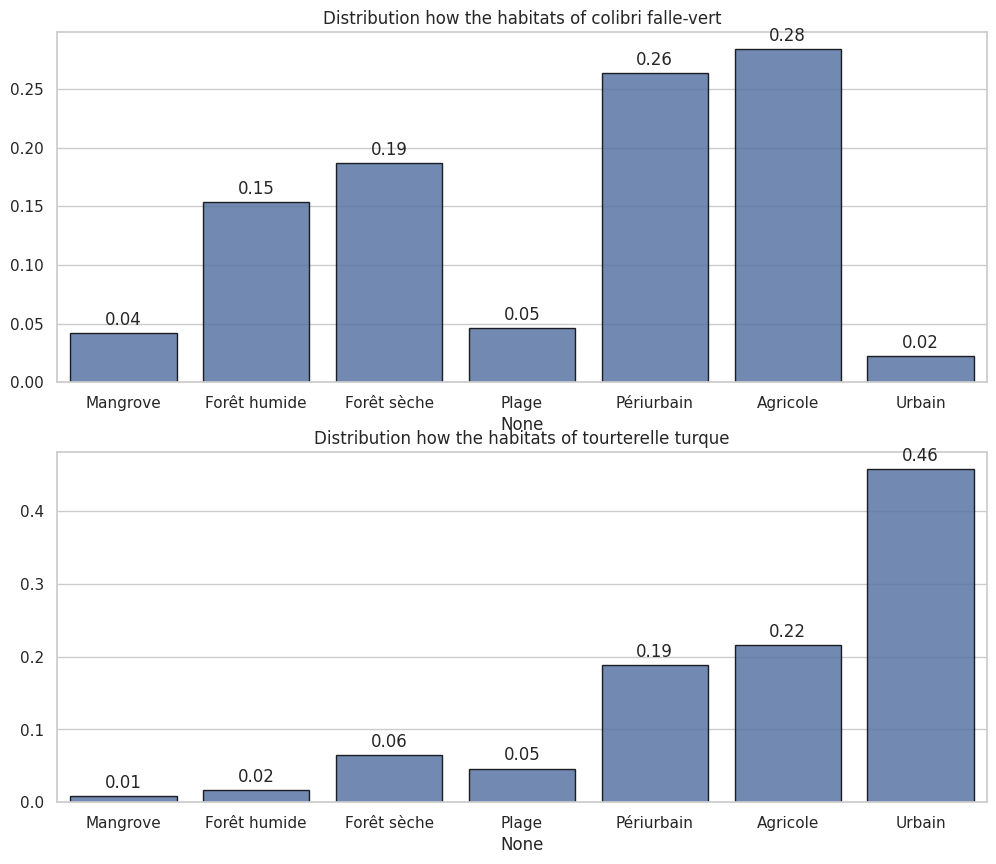

In [183]:

def get_habitat(specie):
    

    df_cut = df_observations[df_observations["clean_espece"] == specie]

    df_cut = df_cut[df_cut["year"] > 2014]

    habitats = pd.Series(0, index = df_sites["Type"].unique())



    for trans, idsite, amount in zip(df_cut["Nom transect"], df_cut["N° point"], df_cut["Amount"]):
        df_sites_cuts = df_sites[df_sites["Transect"] == trans]
        habitat = df_sites_cuts.iloc[int(idsite) - 1]["Type"]
        habitats[habitat] += amount 
    return habitats

habitatMin = get_habitat(minEsp)
habitatMax = get_habitat(maxEsp)

habitatMin = habitatMin / habitatMin.sum()
habitatMax = habitatMax / habitatMax.sum()


fig, axes = plt.subplots(2, 1, figsize =(12, 10))

sns.barplot(x=habitatMin.index, y=habitatMin.values, ax=axes[0], alpha=0.85, edgecolor="black")
axes[0].set_title(f"Distribution how the habitats of {minEsp}")

sns.barplot(x=habitatMax.index, y=habitatMax.values, ax=axes[1], alpha=0.85, edgecolor="black")
axes[1].set_title(f"Distribution how the habitats of {maxEsp}")


for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)

plt.savefig("figures/habitats_specie.jpeg")

In [213]:
mask = evolutionSpecies.apply(lambda s: len(s) > 0 and s.iloc[0] > seuil)
new_series = evolutionSpecies[mask]

evol2 = {name : [0, 0] for name in species}
for key, item in evolutionSpecies.items():

    indG, indD = 0 , 1

    while indD < len(item):
        left = item.iat[indG]
        right = item.iat[indD]
        if right > left:
            evol2[key][0] += right - left
        else:
            evol2[key][1] += left - right
        indG +=1
        indD += 1

specieBiggestEvol = None
val = -np.inf
evol2 = pd.Series(evol2)

for key, tup in evol2.items():

    change = np.abs(tup[0] - tup[1])
    if change > val:
        val = change
        specieBiggestEvol = key

In [ ]:
# Let's get interested to the specie wich have the most diverse living places
# And the specie with the less diverse living place

stdHabitats = pd.Series(0.0, new_series.keys())
stdMin , stdMax = np.inf, -np.inf

specieStdMin, specieStdMax = None, None
for specie in new_series.keys():
    hab = get_habitat(specie)
    # Normalize it
    hab = hab / hab.sum()
    std = hab.std()

    if std > stdMax:
        stdMax = std
        specieStdMax = specie
        habitatMax = hab
        
    if std < stdMin:
        stdMin = std
        specieStdMin = specie
        habitatMin = hab


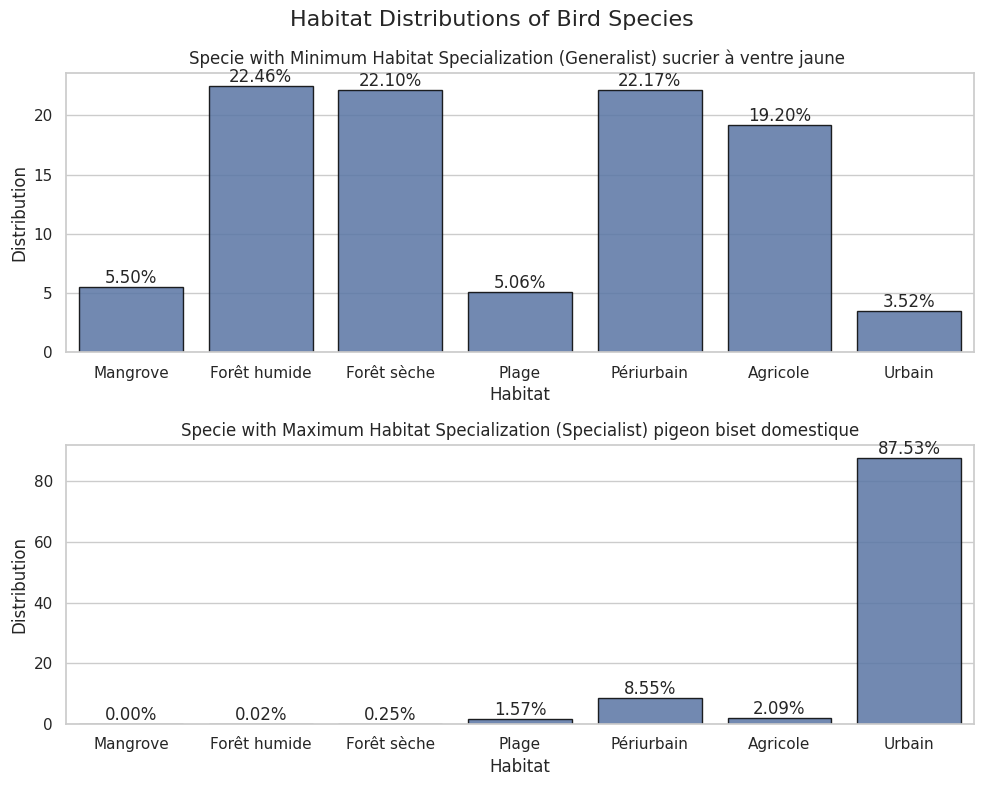

In [224]:
# Create figure with two subplots (vertical)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot habitatMin
sns.barplot(x=habitatMin.index, y = 100 * habitatMin.values, ax=axes[0], alpha=0.85, edgecolor="black")
axes[0].set_title(f"Specie with Minimum Habitat Specialization (Generalist) {specieStdMin} ")
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.2f%%", label_type="edge")
    axes[0].set_xlabel("Habitat")
    axes[0].set_ylabel("Distribution")

# Plot habitatMax
sns.barplot(x=habitatMax.index, y = 100 * habitatMax.values, ax=axes[1], alpha=0.85, edgecolor="black")
axes[1].set_title(f"Specie with Maximum Habitat Specialization (Specialist) {specieStdMax}")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.2f%%", label_type="edge")
    axes[1].set_xlabel("Habitat")
    axes[1].set_ylabel("Distribution")


# Overall figure title
fig.suptitle("Habitat Distributions of Bird Species", fontsize=16)
plt.tight_layout()
plt.show()


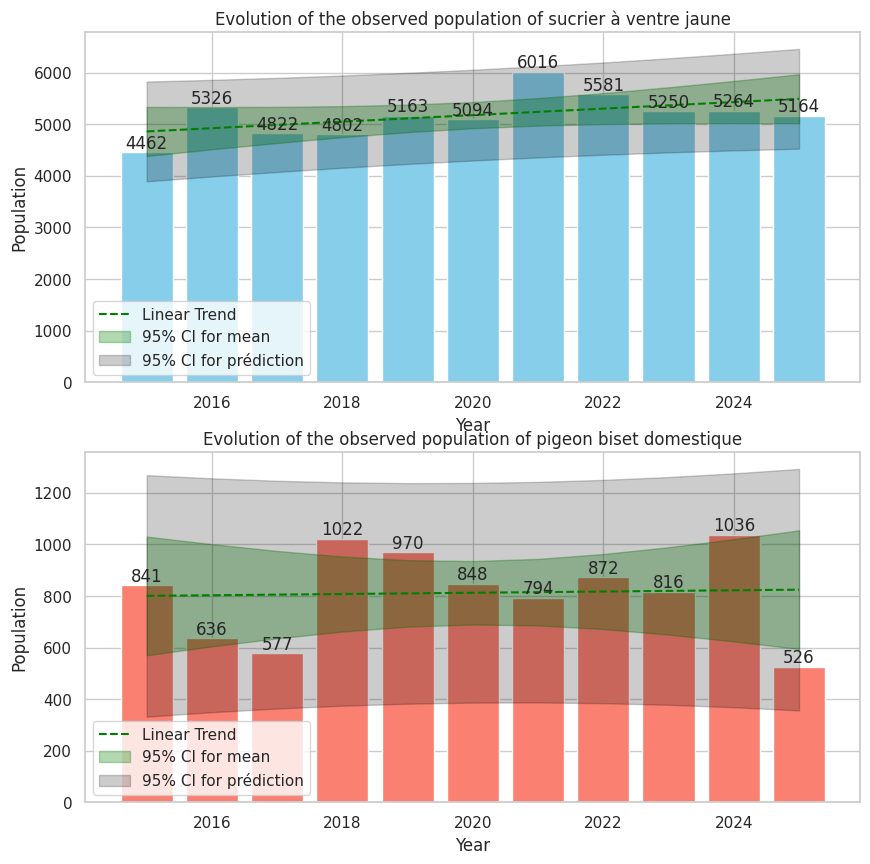

In [229]:
# Finally let's get interested to the evolution of those species of birds

fig, axes = plt.subplots(2, 1, figsize = (10, 10))

plot_with_trend(axes[0], evolutionSpecies[specieStdMin].keys(), evolutionSpecies[specieStdMin], 'skyblue', f'Evolution of the observed population of {specieStdMin}')

# Plot maxEvol
plot_with_trend(axes[1], evolutionSpecies[specieStdMax].keys(), evolutionSpecies[specieStdMax], 'salmon', f'Evolution of the observed population of {specieStdMax}')
plt.savefig("figures/evolution_species_habitat.jpeg")

We can notice that their population is almost steady, so we can deduce the diversity of living places does not really influence on the population.